In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from glob import glob #not used
from IPython.display import display #not used
import matplotlib.pyplot as plt
from math import pi #not used
import seaborn as sns #not used
from scipy import signal
import pywt



**Data cleaning and understanding**

Reading the EEG data from the provided four electrodes by running the file collected during the long blink session equally long (510 points pro session). Conduct the preliminary data processing and visualization steps to gain some insight from the EEG recording:
- Splits and clean the data
- Selects the first 510 points for visualization

1. Are the amplitude value measure as microvolt? This information was not given
2. Are the index time series? If yes issit in seconds or milliseconds? Sampling frequency is 215 Hz at 2 seconds
3. What does 510 points pro session mean? It is an arbitrary decision from the data manager
4. Do we need more information about the four electrodes? No further knowledge is required

**Step 1 Data cleaning and understanding**

1.1 Load data, and parsing it from string to appropriate data type
1.2 Select the first 510 points for visualization

Text(0.5, 1.0, 'The first 510 points of Long Blink')

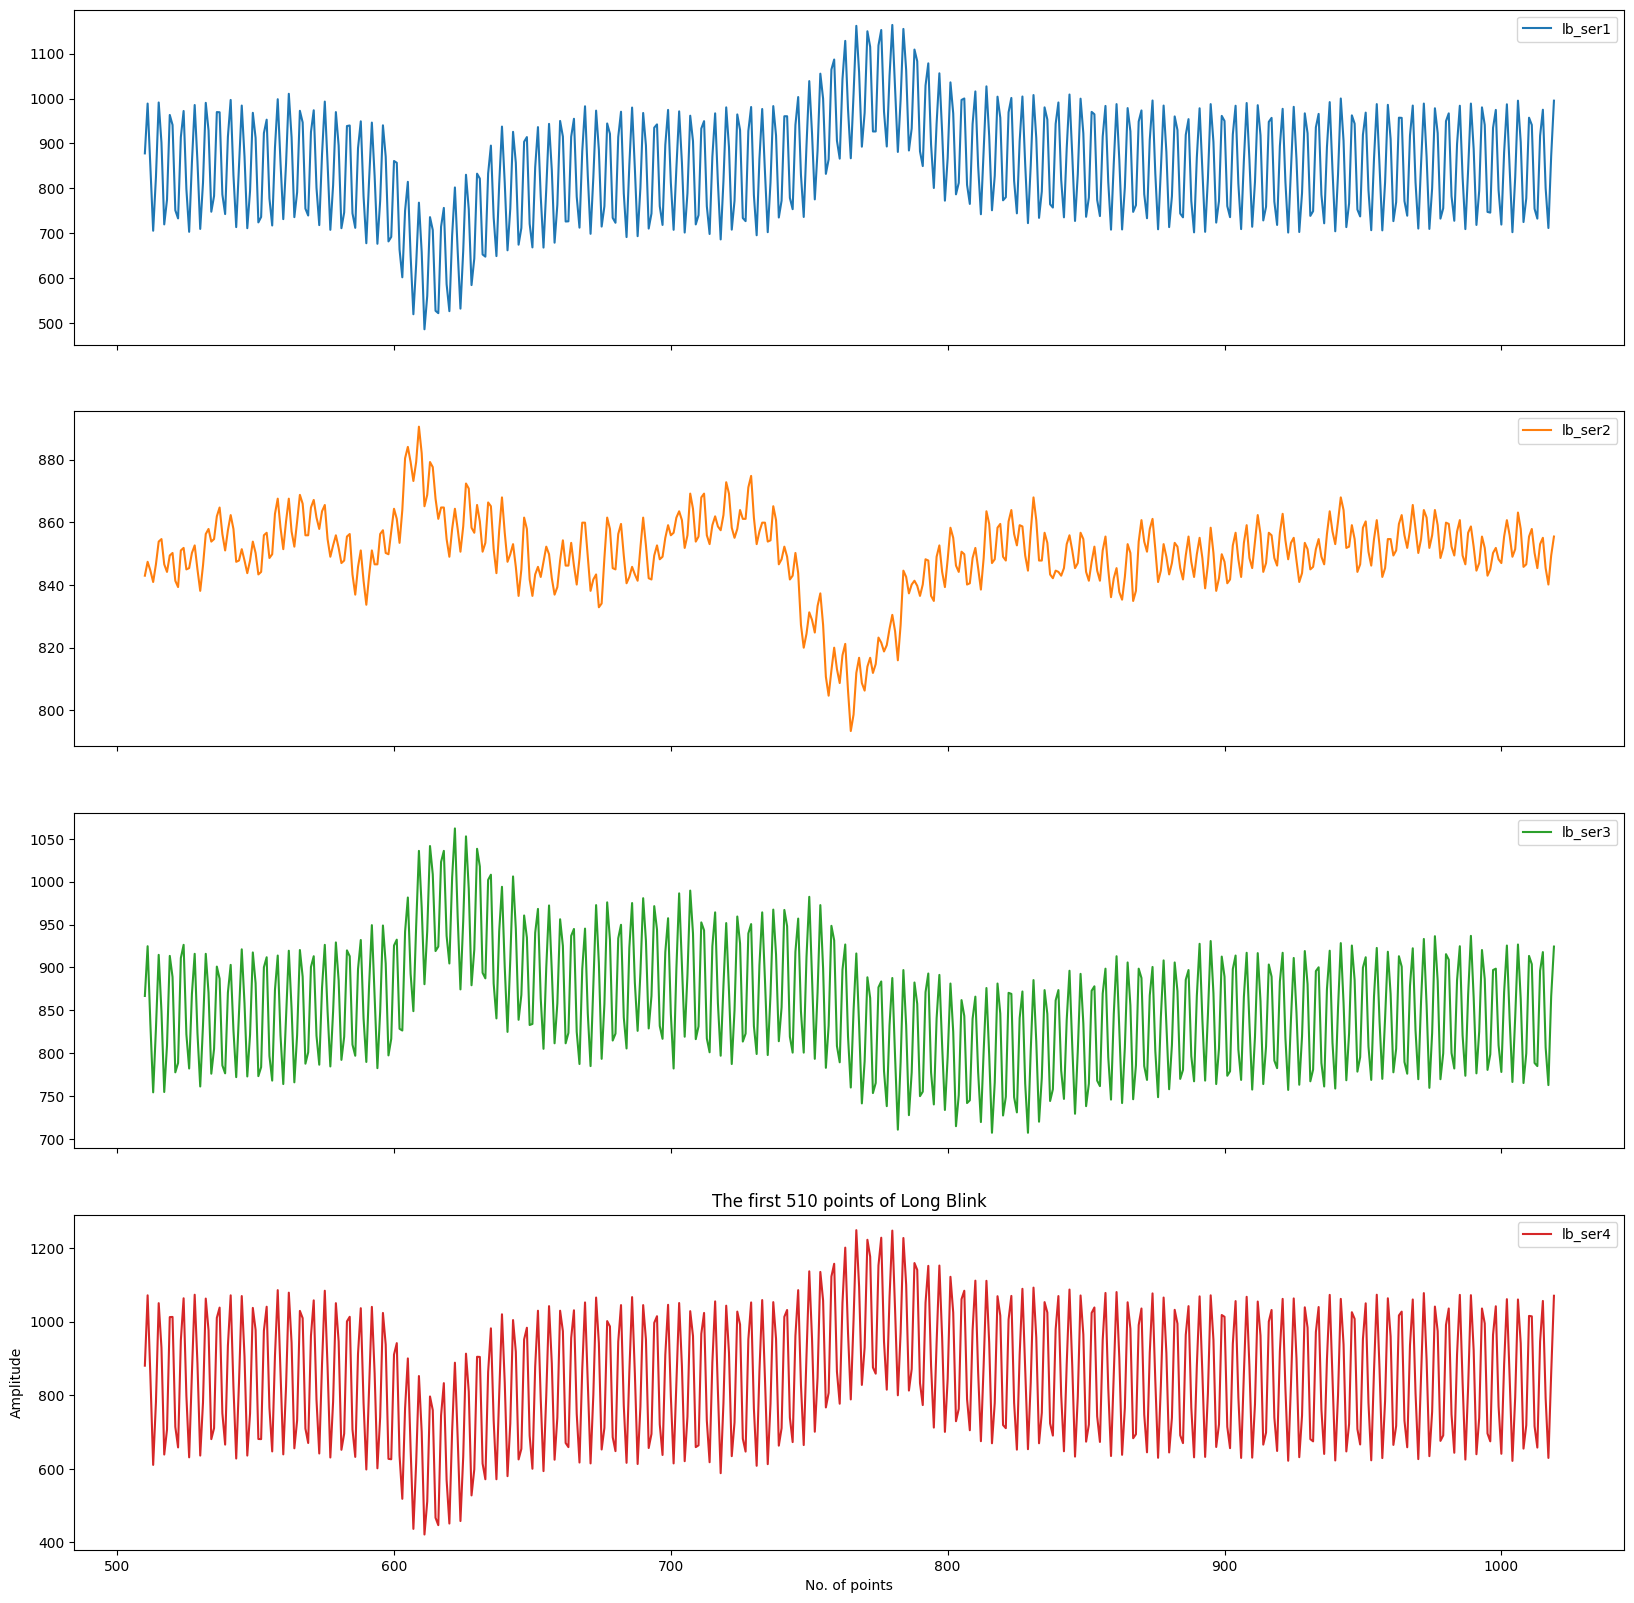

In [2]:
#Long blink data
df1 = pd.read_csv('data\\LongBlink.csv', sep = ",")
df1[['Col1', 'Col2', 'Col3', 'Col4']] = df1['data'].str.split(',', expand=True)
#Remove the original 'HeaderColumn' column
df1.drop(columns=['data'], inplace=True)
df1.head(5)
lb_ser1 = df1.iloc[:,0].str.strip('[').astype(float) #to remove square brackets and convert to float
lb_ser2 = df1.iloc[:,1].astype(float) #convert to float
lb_ser3 = df1.iloc[:,2].astype(float) #convert to float
lb_ser4 = df1.iloc[:,3].str.strip(']').astype(float) #remove square brackets and convert to float
#ser 1,2,3,4 are numpy arrays, length: 25500, dtype: float64
df1 = pd.concat([lb_ser1, lb_ser2, lb_ser3, lb_ser4], axis=1) #concatenate the columns
df1.columns = ['lb_ser1', 'lb_ser2', 'lb_ser3', 'lb_ser4'] #rename the columns
#extract the first 510 points of the data as sample and visualize it
df1_sample = df1.iloc[510:1020] 
df1_sample.plot.line(subplots=True, figsize=(20, 20))
plt.xlabel('No. of points')
plt.ylabel('Amplitude')
plt.title('The first 510 points of Long Blink')

**Step 2: Data format compatibility** 

Generating a .fif file from csv to fit the raw data format used in MNE-python package for analysis

In [3]:
import mne
#source: https://colab.research.google.com/drive/1ro2XBhpUKIlV5JCytetKoNFrVOCgdLAP?usp=sharingLink#scrollTo=T4VzMOJKSXlz
#source: https://mne.tools/dev/auto_tutorials/preprocessing/10_preprocessing_overview.html

n_channels = len(df1.columns)
ch_names = list(df1.columns)
values = df1.T*1e-7 #scale the signal value (but why scale by 1**-7?)
ch_types = ['eeg']*df1.shape[1]

sampling_freq = 215 

info = mne.create_info(ch_names=ch_names, sfreq=sampling_freq, ch_types=ch_types)
raw_lb = mne.io.RawArray(values, info)

raw_lb.save('.\\data\\raw_lb.fif', overwrite=True)

Creating RawArray with float64 data, n_channels=4, n_times=25500
    Range : 0 ... 25499 =      0.000 ...   118.600 secs
Ready.


C:\Users\charl\AppData\Local\Temp\ipykernel_43448\2647259379.py:15: RuntimeWarning: This filename (d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\data\raw_lb.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_lb.save('.\\data\\raw_lb.fif', overwrite=True)


Writing d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\data\raw_lb.fif
Closing d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\data\raw_lb.fif
[done]


**Artifact detection**

MNE-Python includes a few tools for automated detection of certain artifacts (heartbeats and blinks), but one can always visually inspect the data to identify and annotate artifacts as well. Before we look at artifacts we set aside SSP projectors in a separate variable and then remove them from Raw object using del_proj() method so that we can inspect our data in its original, raw state.

In [7]:
ssp_projectors = raw_lb.info['projs']
raw_lb.del_proj()

<RawArray | 4 x 25500 (118.6 s), ~806 kB, data loaded>

**Low-frequency drifts**

Low-frequency drifts are most readlily detected by visual inspection using the basic plot() method, it is helpful to plot a relatively long time spac and to disable channel-wise DC shift correction. Here, 60 seconds is plotted to show all the magnetometer channels.

In [ ]:
eeg_channel = mne.pick_types(raw_lb.info, eeg=True)
raw_lb.plot() # optional to indicate the duration=60 

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 9.526 (s)


d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\.venv\lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


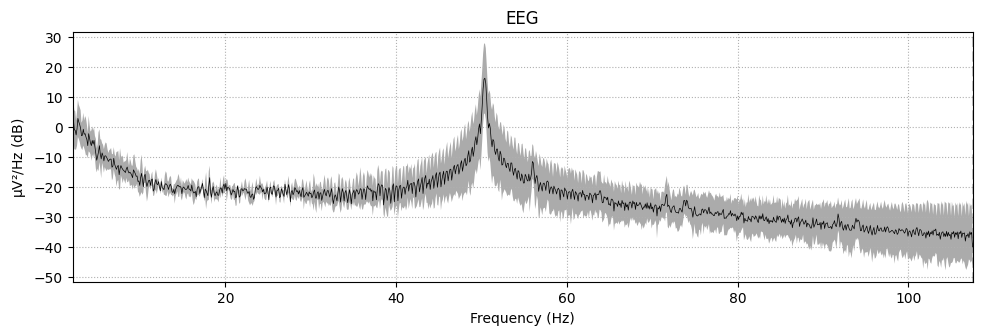

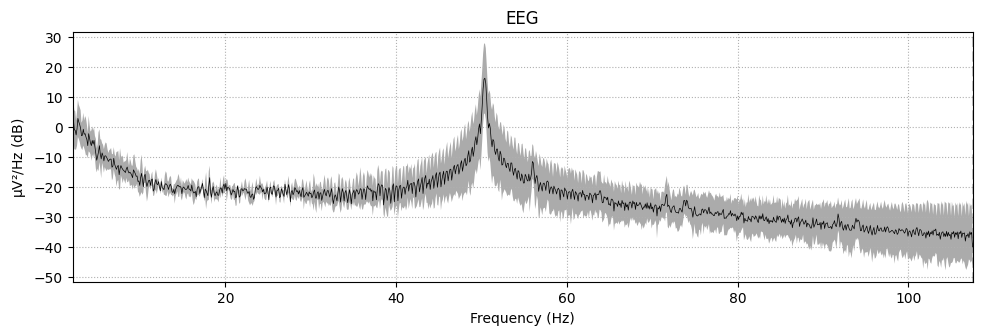

In [15]:
#PSD (power spectral density) provides information about the distribution of power across different frequencies in the EEG signal.
raw_lb.plot_psd(tmin=0, tmax=50, fmin=2, fmax=107.5, average=True) #

In [20]:
# get pandas dataframe from raw format
data_lb = raw_lb.to_data_frame()
data_lb = data_lb.drop("time", axis=1) #drop "time" column
#get pandas series to use in data preprocessing
lb_ser1 = data_lb["lb_ser1"]
lb_ser2 = data_lb["lb_ser2"]
lb_ser3 = data_lb["lb_ser3"]
lb_ser4 = data_lb["lb_ser4"]
data_lb

,lb_ser1,lb_ser2,lb_ser3,lb_ser4
0,83.003663,84.978022,82.278388,82.761905
1,71.963370,84.091575,76.315018,63.179487
2,84.655678,84.655678,85.179487,83.043956
3,98.798535,85.340659,92.351648,106.776557
4,87.959707,84.816850,85.219780,91.223443
...,...,...,...,...
25495,80.868132,84.010989,83.648352,80.223443
25496,72.809524,84.172161,80.666667,67.289377
25497,85.904762,84.937729,86.670330,85.703297
25498,96.945055,85.260073,90.901099,102.908425


**Data Preprocessing**

2.1 Filtering 

source : (https://neuraldatascience.io/7-eeg/erp_filtering.html)
Filtering typically occurs at two points in the EEG pipeline:  at the time the data is recorded and during preprocessing. The filters used during preprocessing are third-order:
* median filter
* low pass filter
* high pass filter
* notch filter

Firstly, the raw data were filtered using the third-order median filter for denoising and smoothing the signal  by replacing each data point with the median value. Subsequently, the fifth-order Butterworth filter was used for low-pass and high-pass filtering to remove unwanted frequencies from the signal.

I learned that it is important to consider Nyquist theorem, where the highest measurable frequency is half the sampling rate. Signal frequencies higher than Nyquist frequency *alias*, thus it is necessary to filter out the components that are higher than Nyuquist frequency (source: https://link.springer.com/content/pdf/10.3758/BF03209412.pdf).  
I will be working with signal that's sampled at 215 Hz at 2 seconds long, starting with long blink data, followed by the short blink data. 



Text(0.5, 1.0, 'The first 510 points of Long Blink')

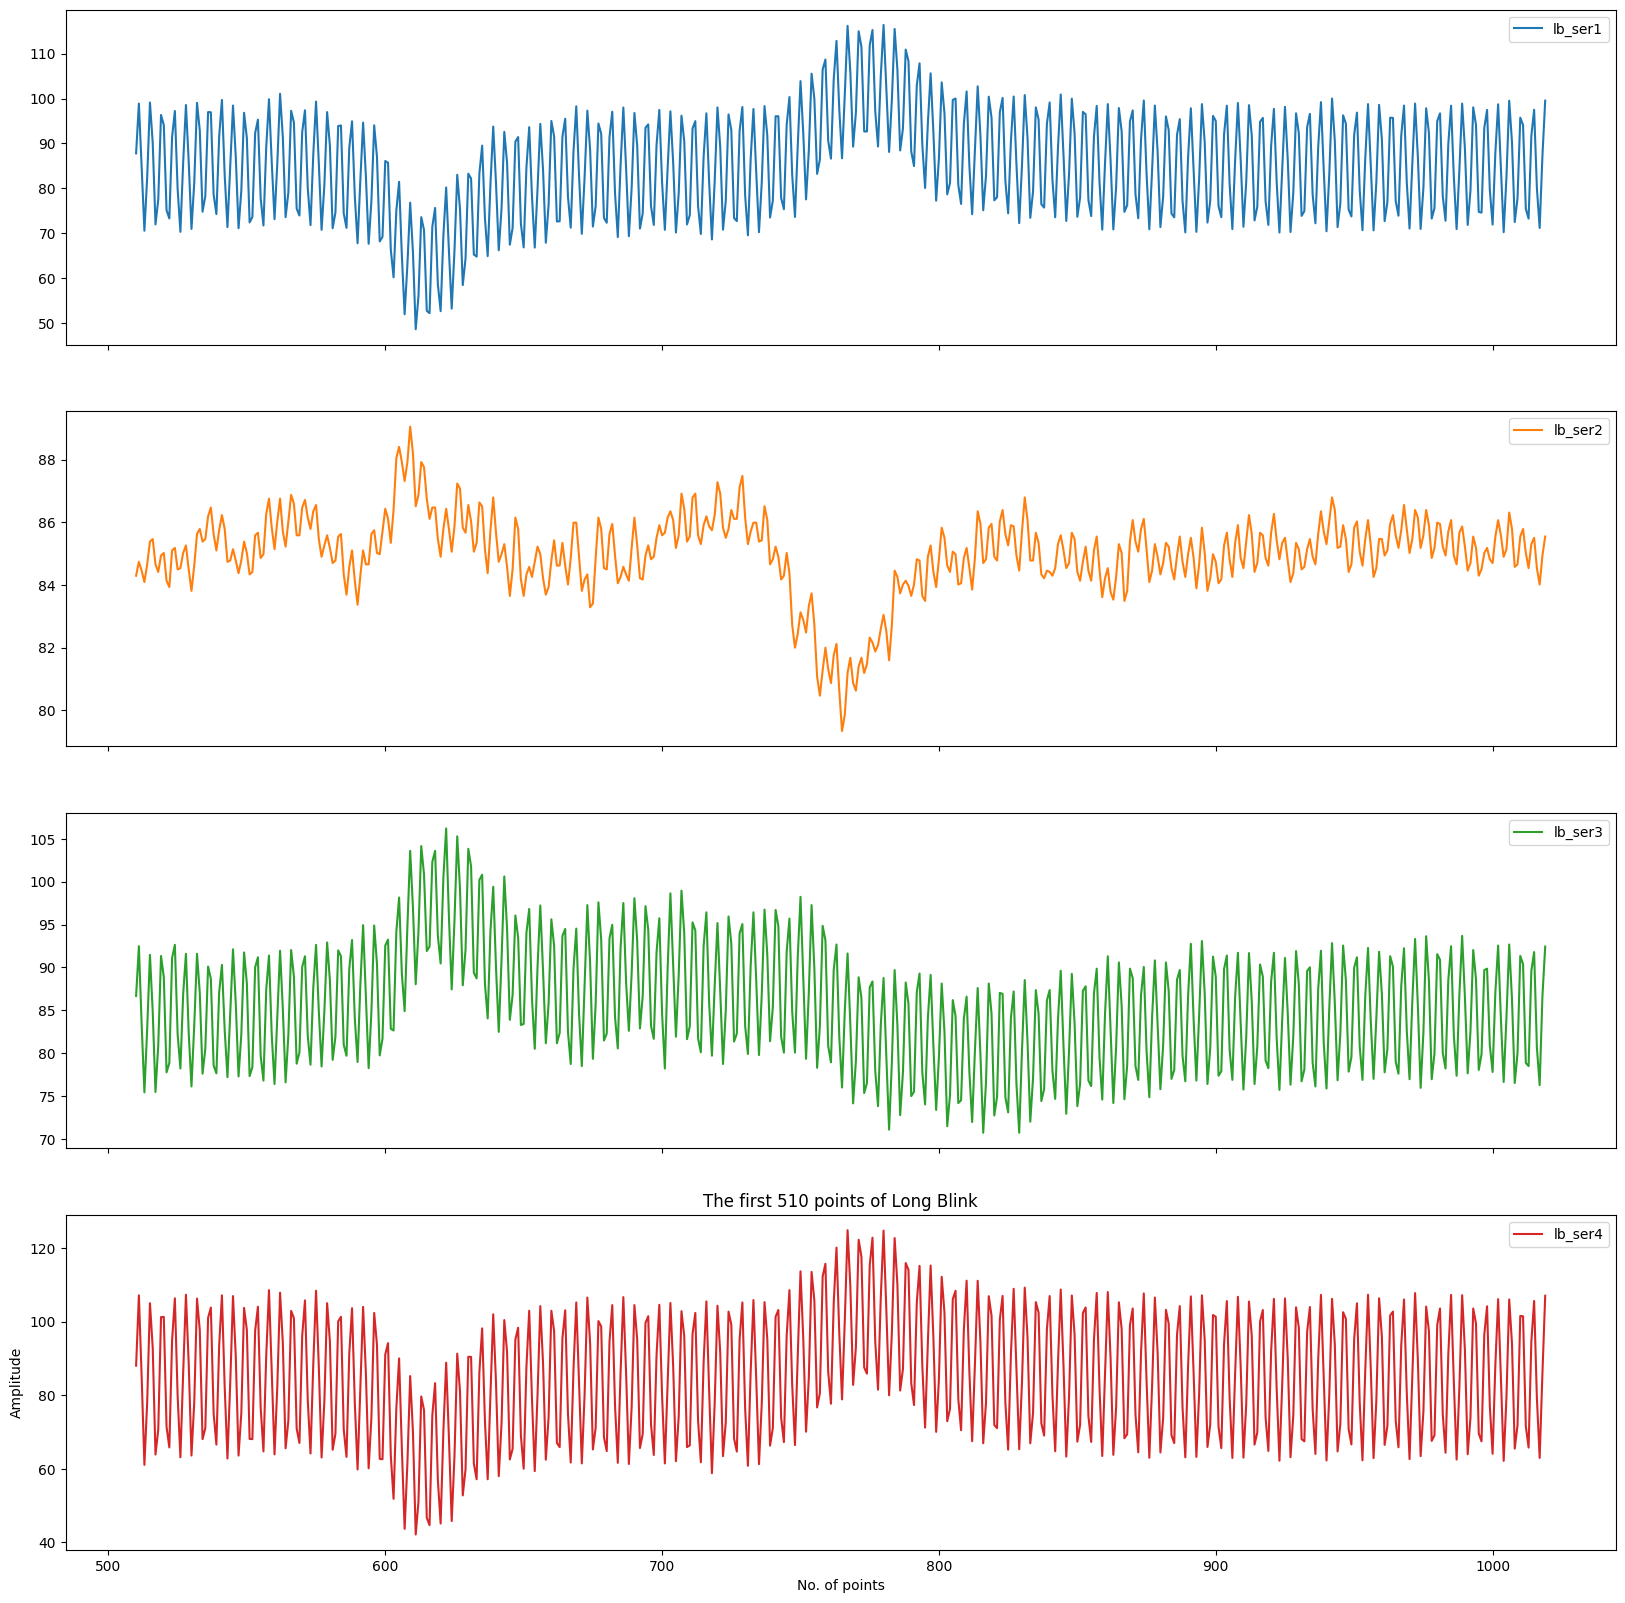

In [21]:
#band pass filter between 0.5 and 40 hz, source: https://www.kaggle.com/code/sam1o1/eeg-signal-processing
Fs = 215;              # Sampling frequency, not used                    
T = 1/Fs;              # Sampling period       
L = 25500;             # Length of signal
t = np.arange(0,L)*T;  # Time vector (use numpy.arange to an array of evenly spaced values between 0 and L-1, multiplied by T to get the time vector)

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.33 * fs #nyquist frequency at 1/3 of the sampling rate is the safest
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sp.signal.lfilter(b, a, data)
    return y

lb_ser1_np = butter_bandpass_filter(lb_ser1, 0.5, 40, 215, 4)
lb_ser2_np = butter_bandpass_filter(lb_ser2, 0.5, 40, 215, 4)
lb_ser3_np = butter_bandpass_filter(lb_ser3, 0.5, 40, 215, 4)
lb_ser4_np = butter_bandpass_filter(lb_ser4, 0.5, 40, 215, 4)


data_lb[510:1020].plot(subplots=True, figsize=(20,20))
plt.xlabel('No. of points')
plt.ylabel('Amplitude')
plt.title('The first 510 points of Long Blink')

In [ ]:
#apply the median filter function
def median(signal):# input: numpy array 1D (one column)
    array=np.array(signal)   
    #applying the median filter
    med_filtered=sp.signal.medfilt(array, kernel_size=3) # applying the median filter order3(kernel_size=3)
    return  med_filtered # return the med-filtered signal: numpy array 1D

df1.iloc[:,0] = median(df1.iloc[:,0])
df1.plot.line(subplots=True, figsize=(20, 20))

In [ ]:
#apply notch filter at 50hz
def Implement_Notch_Filter(time, band, freq, ripple, order, filter_type, data):
    from scipy.signal import iirfilter
    fs   = 1/time 
    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq 
    high = high/nyq
    b, a = iirfilter(order, [low, high], rp=ripple, btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

df1.iloc[:,0] = Implement_Notch_Filter(1/215, 4, 50, 1, 2, 'butter', df1.iloc[:,0])
df1.plot.line(subplots=True, figsize=(20, 20))


In [ ]:
import pywt
# Wavelet decomposition
wavelet = 'db1'  # Choose a wavelet (Daubechies wavelet of order 1 in this case)
level = 4  # Number of decomposition levels
signal = df1.iloc[:,0]  # Signal to be decomposed

coeffs = pywt.wavedec(signal, wavelet, level=level)

# Plot the original signal and its wavelet coefficients
plt.figure(figsize=(12, 6))
plt.subplot(level + 2, 1, 1)
plt.plot(signal)
plt.title('Original Signal')

for i in range(level):
    plt.subplot(level + 2, 1, i + 2)
    plt.plot(coeffs[i])
    plt.title(f'Level {i + 1} Coefficients')

plt.subplot(level + 2, 1, level + 2)
plt.plot(coeffs[level])
plt.title(f'Approximation Coefficients (Level {level})')

plt.tight_layout()
plt.show()

In [ ]:
#code source: https://www.daanmichiels.com/blog/2017/10/filtering-eeg-signals-using-scipy/
#apply signal.firwin function : FIR (finite impulse response) filter to process the signal
#choose the cutoff frequency
# cutoff_freq = [0.01, 0.06] #Hz
# filter = signal.firwin(430, [0.01, 0.06], pass_zero=False)

# plt.figure(figsize=(12, 6))
# plt.plot(filter)
# plt.title("Filtered EEG Data")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
#Create a function to apply the filters to the signal processing pipeline
def signalProcessing(): 

In [ ]:
#FIR (finite impulse response) filter to process in series 1 and compare the results
lb1_clean = signal.convolve(lb_ser1, filter, mode='same')
plt.figure(figsize=(18,4))
plt.plot(lb_ser1, alpha=1) #alpha is for transparency
plt.plot(lb1_clean, color = "green") 
plt.show()

In [ ]:
#FIR (finite impulse response) filter to process the first 510 points in series 2 and compare the results
lb2_clean = signal.convolve(lb_ser2, filter, mode='same')
plt.figure(figsize=(18,4))
plt.plot(lb_ser2, alpha=1) #alpha is for transparency
plt.plot(lb2_clean) 
plt.show()

In [ ]:
#FIR (finite impulse response) filter to process the first 510 points in series 3 and compare the results
lb3_clean = signal.convolve(lb_ser3, filter, mode='same')
plt.figure(figsize=(18,4))
plt.plot(lb_ser3, alpha=1) #alpha is for transparency
plt.plot(lb3_clean) 
plt.show()

In [ ]:
#FIR (finite impulse response) filter to process the first 510 points in series 4 and compare the results
lb4_clean = signal.convolve(lb_ser4, filter, mode='same')
plt.figure(figsize=(18,4))
plt.plot(lb_ser4, alpha=1) #alpha is for transparency
plt.plot(lb4_clean) 
plt.show()

In [ ]:
#Short blink
df2 = pd.read_csv('data\\ShortBlink.csv', sep = ",")
df2[['Col1', 'Col2', 'Col3', 'Col4']] = df2['data'].str.split(',', expand=True)
# Remove the original 'HeaderColumn' column
df2.drop(columns=['data'], inplace=True)
df2.head(5)
sb_ser1 = df2.iloc[:,0].str.strip('[').astype(float) #remove square brackets and convert to float
sb_ser2 = df2.iloc[:,1].astype(float) #convert to float
sb_ser3 = df2.iloc[:,2].astype(float) #convert to float
sb_ser4 = df2.iloc[:,3].str.strip(']').astype(float) #remove square brackets and convert to float
df2 = pd.concat([sb_ser1, sb_ser2, sb_ser3, sb_ser4], axis=1)
print(df2)
df2 = df2.iloc[0:510]
df2.plot.line(subplots=True, figsize=(20, 20))
df2

In [ ]:
# merged_df = pd.merge(df1, df2, how='outer', left_index=True, right_index=True)
# merged_df.plot.line(subplots=True, figsize=(20, 20))


In [ ]:
#FIR (finite impulse response) filter to process the first 510 points in series 1 and compare the results
sb1_clean = signal.convolve(sb_ser1, filter, mode='same')
plt.figure(figsize=(18,4))
plt.plot(sb_ser1, alpha=1) #alpha is for transparency
plt.plot(sb1_clean, color = "green") 
plt.show()

In [ ]:
#FIR (finite impulse response) filter to process the first 510 points in series 1 and compare the results
sb2_clean = signal.convolve(sb_ser2, filter, mode='same')
plt.figure(figsize=(18,4))
plt.plot(sb_ser2, alpha=1) #alpha is for transparency
plt.plot(sb2_clean, color = "green") 
plt.show()

In [ ]:
#FIR (finite impulse response) filter to process the first 510 points in series 1 and compare the results
sb3_clean = signal.convolve(sb_ser3, filter, mode='same')
plt.figure(figsize=(18,4))
plt.plot(sb_ser3, alpha=1) #alpha is for transparency
plt.plot(sb3_clean, color = "green") 
plt.show()

In [ ]:
#FIR (finite impulse response) filter to process the first 510 points in series 1 and compare the results
sb4_clean = signal.convolve(sb_ser4, filter, mode='same')
plt.figure(figsize=(18,4))
plt.plot(sb_ser4, alpha=1) #alpha is for transparency
plt.plot(sb4_clean, color = "green") 
plt.show()

In [ ]:
#Independent Component Analysis (ICA) for artifact removal
